In [3]:
from safety_gymnasium.wrappers.gymnasium_conversion import make_gymnasium_environment
import gymnasium as gym
from torch.utils.data.dataset import Dataset, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import safety_gymnasium
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import numpy as np
from threading import Thread
from pynput.keyboard import Key, Listener
import time

from stable_baselines3 import PPO   

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3 import PPO, A2C, SAC, TD3
from stable_baselines3.common.evaluation import evaluate_policy

import wandb
from wandb.integration.sb3 import WandbCallback

import pandas as pd
import numpy as np

import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn

from models import Actor,Critic
from torch.autograd import Variable
from utils import Memory,OUNoise

In [22]:
def get_trajectories_df():
    '''
    Returns an Empty Trajectories Dataframe with the required columns for PointCircle Environment
    It is used to collect the expert safe trajectories
    '''
    
    sensor_names = ['accelerometer','velocimeter','gyro','magnetometer','circle_lidar'] #Having a seperate list to maintain the order of names
    obs_config = {'accelerometer':3,'velocimeter':3,'gyro':3,'magnetometer':3,'circle_lidar':16}
    columns_obs = []
    for sensor_name in sensor_names:
        num_obs_vals = obs_config[sensor_name]
        columns_obs.extend(['obs_'+sensor_name+'_'+str(i) for i in range(num_obs_vals)])

    columns_actions = ['act_force_linear','act_angular_velocity']

    traj_columns_list = ['env_code','Episode','Time_Step'] + columns_obs + ['x','y','theta']+ columns_actions + ['reward','cost']
    # columns_obs = ['accelerometer_{i}' for i in range(3)] + ['velocimeter_{i}' for i in range(3)] 
    trajectories_df = pd.DataFrame(columns=traj_columns_list)
    return trajectories_df

def scale_angle(angle):
    '''Scales the Angles between 0 and 360, Input must be in degrees'''
    
    angle_scaled = angle%360

    if angle_scaled<0:
        angle_scaled+=360
    
    return angle_scaled

def get_x_vals(x_indices,lidar_resolution):
    '''Returns in Degrees'''

    index_to_angle_factor = 360/lidar_resolution
    x_vals = x_indices*index_to_angle_factor

    # Handling the Case where there is a jump
    # if len(x_indices)==0:
    #     print(x_indices)
    if max(x_indices)-min(x_indices)==2:
        pass

    else:
        if 1 in x_indices:
            x_vals[0:2] += 360
        else:
            x_vals[0] += 360

    return x_vals

def get_lidar_r_theta(lidar_values,lidar_resolution,max_lidar_distance):
    '''
    The lidar values are processed and location of the center of the circle is returned from agent's frame of reference
    
    Returns
        theta_lidar_rad, r: Position of the Circle Centre wrt agent
        info_lidar: Has info if the agent is within or out of limits
    '''
    x_indices = np.where(lidar_values>0)[0]
    if len(x_indices)>3:
        raise
        # We assumed that the lidar generates only 3 non-zero values, get_x_vals() uses this assumption

    if len(x_indices)>0:
        y_vals = lidar_values[x_indices]
        x_vals = get_x_vals(x_indices,lidar_resolution)

        a,b,c = np.polyfit(x_vals,y_vals,2)
        theta_lidar = (-b/(2*a)) # Its in degrees
        lidar_max = c - b**2/(4*a)
        r = (1-lidar_max)*max_lidar_distance

        theta_lidar = scale_angle(theta_lidar)+180/lidar_resolution
        info_lidar = {'x_vals':x_vals,'y_vals':y_vals,'within_limits':True}

    else:
        theta_lidar = -1
        r = max_lidar_distance
        info_lidar = {'x_vals':-1,'y_vals':-1,'within_limits':False}

    theta_lidar_rad = theta_lidar*np.pi/180
    return theta_lidar_rad,r,info_lidar

def get_coords(obs,max_lidar_distance,lidar_resolution):
    '''Processes the 16-dim observation vector and return (x,y,theta) coordinates of the agent
    by using the magnetometer for orientation and lidar for distance and angle from the origin
    '''
    
    # Processing the State
    lidar_values = obs[-16:]
    mag0 = obs[9]
    mag1 = obs[10]
    theta_local = np.arctan2(mag0,mag1)
    # theta_lidar = (np.argmax(lidar_values)+1)*2*np.pi/lidar_resolution
    theta_lidar,r,info_lidar = get_lidar_r_theta(lidar_values,lidar_resolution,max_lidar_distance)
    
    if info_lidar['within_limits']==False:
        # print("Agent OUTSIDE LIMITS")
        return -1,-1,-1,info_lidar

    r = (1-max(lidar_values))*max_lidar_distance

    theta_bot = theta_lidar+theta_local+np.pi
    theta_bot_scaled = scale_angle(theta_bot*180/np.pi)*np.pi/180 #This is to bring it back to [0,2pi]

    x,y = r*np.cos(theta_bot_scaled),r*np.sin(theta_bot_scaled)
    # print("X Vals: {} | Y vals : {} | Theta Lidar: {:.2f} | Theta Local: {:.2f} | theta_bot_scaled :{:.2f} ".format(np.round(info_lidar['x_vals'],2),np.round(info_lidar['y_vals'],2),theta_lidar*180/np.pi,theta_local*180/np.pi,theta_bot_scaled*180/np.pi))

    return x,y,theta_local,info_lidar

def plot_trajectories(plot_trajectories_df,truly_safe_bounds,marginally_safe_bounds = [-1.1,1.1],ylim = 3,linewidth=0.1):
    episode_arr = plot_trajectories_df.Episode.unique()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    for episode in episode_arr:
        trajectory_df = plot_trajectories_df[plot_trajectories_df.Episode==episode]
        ax.plot(plot_trajectories_df.x,plot_trajectories_df.y,color='b',linewidth=linewidth)


    # Plotting Truly Safe Set, Marginally Safe Set and Maximum Rewarding Circle
    ax.plot([truly_safe_bounds[0],truly_safe_bounds[0]],[-ylim,ylim],color='g',linewidth=3)
    ax.plot([truly_safe_bounds[1],truly_safe_bounds[1]],[-ylim,ylim],color='g',linewidth=3)
    ax.plot([marginally_safe_bounds[0],marginally_safe_bounds[0]],[-ylim,ylim],color='r',linewidth=3)
    ax.plot([marginally_safe_bounds[1],marginally_safe_bounds[1]],[-ylim,ylim],color='r',linewidth=3)
    ax.add_patch(Circle((0, 0), 1.5, fill=False))

    ax.set_xlim([-2,2])
    ax.set_aspect('equal')

def print_logging_dict(logging_dict):

    for key in logging_dict:
        print("{}:{:.2f}".format(key,logging_dict[key]),end=' | ')

    print()

    


#### Training PPO using Stable Baselines Environment
Proximal Policy Algorithm (PPO) from the Stable Baselines Environment was used to train the agent to assess how a pure RL algorithm would perform. The agent in this case is indifferent to the safety contraints. The implementation using Stable Baselines is fairly straightforward.

Make sure to use the "make_gymnasium_environment" method to create the gym environment compatible with the stable baselines model. The usual safety_gymnasium environments created using "safety_gymnasium.make" has a slightly different .step() function. In the former, <em>cost</em> is returned inside <em>info</em> while the <em>cost</em> is returned as a seperate variable in the latter


In [64]:
def get_canvas(lidar_values,image_size=(256,256,3)):
    roi_space = 1
    x_pixel_range = image_size[0]*roi_space
    y_pixel_range = image_size[1]*roi_space
    max_lidar = 6
    radius = int(0.01*x_pixel_range)
    thickness = int(0.01*x_pixel_range)
    color = (255,0,0)

    canvas = np.ones(image_size,dtype=np.uint8)*255
    angles = np.linspace(0,2*np.pi,len(lidar_values))

    lidar_pixel_points = []
    for angle,lidar_value in zip(angles,lidar_values):

        # if lidar_value==0:
        #     lidar_value = max_lidar

        x_euclidean = lidar_value*np.cos(angle)
        y_euclidean = lidar_value*np.sin(angle)

        x_pixel = int(x_pixel_range/2*x_euclidean/max_lidar+x_pixel_range/2)
        y_pixel = int(y_pixel_range/2 - y_pixel_range/2*y_euclidean/max_lidar)

        # print(x_euclidean,y_euclidean,x_pixel,y_pixel)

        cv2.circle(canvas,(x_pixel,y_pixel),radius,color,thickness)
        lidar_pixel_points.append([x_pixel,y_pixel])

    pts = np.array(lidar_pixel_points).astype(np.int32).reshape((-1, 1, 2))
    cv2.polylines(canvas,[pts],isClosed=True,color=(0,255,0),thickness=thickness)

    return canvas
        

In [ ]:
config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 100000,
    "env_name": "CartPole-v1",
}
run = wandb.init(
    project="sb3",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)


# def make_env(env):
#     env = gym.make(config["env_name"])
#     env = Monitor(env)  # record stats such as returns
#     return env


# env = DummyVecEnv([make_env])
# env = VecVideoRecorder(
#     env,
#     f"videos/{run.id}",
#     record_video_trigger=lambda x: x % 2000 == 0,
#     video_length=200,
# )

agent_type = 'Point'
env_code = 1
env_name = 'Safety{}Circle{}Gymnasium-v0'.format(agent_type,env_code)
env = make_gymnasium_environment(env_name,render_mode=None)

model = PPO(config["policy_type"], env, verbose=1, tensorboard_log=f"runs/{run.id}")
model.learn(
    total_timesteps=config["total_timesteps"],
    callback=WandbCallback(
        gradient_save_freq=100,
        model_save_path=f"models/{run.id}",
        verbose=2,
    ),
)
run.finish()

# model_save_path = 'Saved_Models/ppo_200k'
# model.save(model_save_path)

In [ ]:
model_save_path = 'Saved_Models/ppo_200k'
model_loaded = PPO.load(model_save_path)

obs,_ = env.reset()
while True:
    # act = env.action_space.sample()
    action, _state = model_loaded.predict(obs, deterministic=True)      
    obs, reward, terminated, truncated, info = env.step(action)

    lidar_values = 1- obs[-16:]
    if (lidar_values>1).sum()>0:
        break
    canvas = get_canvas(lidar_values)
    env.render()
    cv2.imshow("lidar",canvas)
    # cv2.imshow("frame",frame)

    cv2.waitKey(10)

    if terminated or truncated:
        print("### Episode Terminated ###")
        observation, info = env.reset()
        

#### Expert Data Collection and Behaviour Cloning

This section was implemented to try the approach where expert human trajectories are recorded and safe behaviour is learnt from these trajectories. Behaviour Cloning is implemented. However, this approach suffered from compounding error and a heuristic based CSP is implemented later

In [1]:
def expert_data_collection(env,trajectories_df, wandb_log=False,num_episodes = 10):
    episode = 0

    obs, info = env.reset()

    dummy_action = env.action_space.sample()
    terminated, truncated = False, False
    ep_ret, ep_cost = 0, 0
    obs_len = env.observation_space.shape[0]
    act_len = env.action_space.shape[0]
    max_lidar_distance = 6
    lidar_resolution = 16
    df_row = np.zeros(len(trajectories_df.columns))

    if wandb_log:
        wandb.init(project='safety_gymnasium')

    for _ in range(num_episodes):
        episode += 1
        ep_ret, ep_cost = 0, 0
        time_step = 0

        while True:
            time_step +=1
            assert env.observation_space.contains(obs)
            obs, reward, cost, terminated, truncated, info = env.step(dummy_action)

            x,y,theta_local,info_lidar = get_coords(obs,max_lidar_distance,lidar_resolution)

            if info_lidar['within_limits']==False:
                observation, info = env.reset()
                break
            
            # print("x,y,theta: ({:.2f},{:.2f},{:.2f})".format(x,y,theta_local*180/np.pi))
            df_row[0] = env_code
            df_row[1] = episode
            df_row[2] = time_step
            df_row[3:3+obs_len] = obs
            df_row[3+obs_len:3+obs_len+3] = np.array([x,y,theta_local*180/np.pi])
            df_row[-2-act_len:-2] = info['action_keyboard']
            df_row[-2] = reward
            df_row[-1] = cost

            # print(df_row)
            trajectories_df.loc[len(trajectories_df.index)] = df_row

            ep_ret += reward
            ep_cost += cost



            if terminated or truncated:
                print("Episode: {} | Reward: {:.2f} | Cost: {:.2f}".format(episode,ep_ret,ep_cost))
                observation, info = env.reset()

                logging_dict = {'Episode':episode,
                                'TimeStep':time_step,
                                'Reward': ep_ret,
                                'Cost':ep_cost
                                }
                
                if wandb_log:
                    wandb.log(logging_dict)
                print_logging_dict(logging_dict)
                break
            
    if wandb_log:
        wandb.finish()

    env.close()

    return trajectories_df

In [48]:
agent_type = 'Point'
env_code = 1
env_name = 'Safety{}Circle{}Debug-v0'.format(agent_type,env_code)
env = safety_gymnasium.make(env_name, render_mode='human')
trajectories_df = get_trajectories_df() # Creates an empty dataframe to record the trajectories

In [49]:
expert_data_collection(env,trajectories_df,wandb_log=False,num_episodes=5)

Episode: 1 | Reward: 41.88 | Cost: 118.00
Episode:1.00 | TimeStep:500.00 | Reward:41.88 | Cost:118.00 | 
Episode: 2 | Reward: 50.81 | Cost: 195.00
Episode:2.00 | TimeStep:500.00 | Reward:50.81 | Cost:195.00 | 
Episode: 3 | Reward: 53.63 | Cost: 208.00
Episode:3.00 | TimeStep:500.00 | Reward:53.63 | Cost:208.00 | 
Episode: 4 | Reward: 52.14 | Cost: 175.00
Episode:4.00 | TimeStep:500.00 | Reward:52.14 | Cost:175.00 | 
Episode: 5 | Reward: 51.56 | Cost: 218.00
Episode:5.00 | TimeStep:500.00 | Reward:51.56 | Cost:218.00 | 


,env_code,Episode,Time_Step,obs_accelerometer_0,obs_accelerometer_1,obs_accelerometer_2,obs_velocimeter_0,obs_velocimeter_1,obs_velocimeter_2,obs_gyro_0,...,obs_circle_lidar_13,obs_circle_lidar_14,obs_circle_lidar_15,x,y,theta,act_force_linear,act_angular_velocity,reward,cost
0,1.0,1.0,2.0,0.000000,0.000000,9.81,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.037692,-0.526693,34.740927,0.0,0.0,0.000000,0.0
1,1.0,1.0,2.0,0.000000,0.000000,9.81,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.037692,-0.526693,34.740927,0.0,0.0,0.000000,0.0
2,1.0,1.0,3.0,0.000000,0.000000,9.81,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.037692,-0.526693,34.740927,0.0,0.0,0.000000,0.0
3,1.0,1.0,4.0,0.000000,0.000000,9.81,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.037692,-0.526693,34.740927,0.0,0.0,0.000000,0.0
4,1.0,1.0,5.0,0.000000,0.000000,9.81,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.037692,-0.526693,34.740927,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1.0,5.0,496.0,1.258293,1.897972,9.81,0.934861,-0.984052,0.0,0.0,...,0.0,0.0,0.0,-1.246304,-1.254880,-12.921978,1.0,1.0,0.103544,1.0
2496,1.0,5.0,497.0,1.321897,1.929434,9.81,0.901818,-1.000443,0.0,0.0,...,0.0,0.0,0.0,-1.232122,-1.277892,-9.527660,1.0,1.0,0.102692,1.0
2497,1.0,5.0,498.0,1.384780,1.956012,9.81,0.869156,-1.014296,0.0,0.0,...,0.0,0.0,0.0,-1.217293,-1.300234,-6.134043,1.0,1.0,0.101821,1.0
2498,1.0,5.0,499.0,1.446695,1.977944,9.81,0.837002,-1.025736,0.0,0.0,...,0.0,0.0,0.0,-1.201832,-1.321860,-2.741016,1.0,1.0,0.100927,1.0


In [43]:
unsafe_episodes = trajectories_df[trajectories_df.cost==1].Episode.unique()
safe_trajectories_df = trajectories_df[~trajectories_df.Episode.isin(unsafe_episodes)]
safe_trajectories_df = safe_trajectories_df[abs(safe_trajectories_df.y)<3]

safe_trajectories_df

,env_code,Episode,Time_Step,obs_accelerometer_0,obs_accelerometer_1,obs_accelerometer_2,obs_velocimeter_0,obs_velocimeter_1,obs_velocimeter_2,obs_gyro_0,...,obs_circle_lidar_13,obs_circle_lidar_14,obs_circle_lidar_15,x,y,theta,act_force_linear,act_angular_velocity,reward,cost
0,1.0,1.0,2.0,0.000000,0.000000,9.81,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.612942,-0.001661,-0.329798,81.804773,0.0,0.0,0.000000,0.0
1,1.0,1.0,2.0,0.000000,0.000000,9.81,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.612942,-0.001661,-0.329798,81.804773,0.0,0.0,0.000000,0.0
2,1.0,1.0,3.0,0.000000,0.000000,9.81,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.612942,-0.001661,-0.329798,81.804773,0.0,0.0,0.000000,0.0
3,1.0,1.0,4.0,0.000000,0.000000,9.81,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.612942,-0.001661,-0.329798,81.804773,0.0,0.0,0.000000,0.0
4,1.0,1.0,5.0,0.000000,0.000000,9.81,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.612942,-0.001661,-0.329798,81.804773,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,1.0,10.0,496.0,0.366448,0.572323,9.81,1.398974,-0.302811,0.0,0.0,...,0.0,0.0,0.000000,0.735353,0.168280,103.873891,1.0,1.0,0.080427,0.0
5496,1.0,10.0,497.0,0.390991,0.722405,9.81,1.386313,-0.373213,0.0,0.0,...,0.0,0.0,0.000000,0.734371,0.196939,107.296529,1.0,1.0,0.080480,0.0
5497,1.0,10.0,498.0,0.421911,0.851554,9.81,1.370123,-0.439995,0.0,0.0,...,0.0,0.0,0.000000,0.733069,0.225662,110.717264,1.0,1.0,0.080502,0.0
5498,1.0,10.0,499.0,0.458951,0.973133,9.81,1.350757,-0.503146,0.0,0.0,...,0.0,0.0,0.000000,0.731390,0.254421,114.135137,1.0,1.0,0.080502,0.0


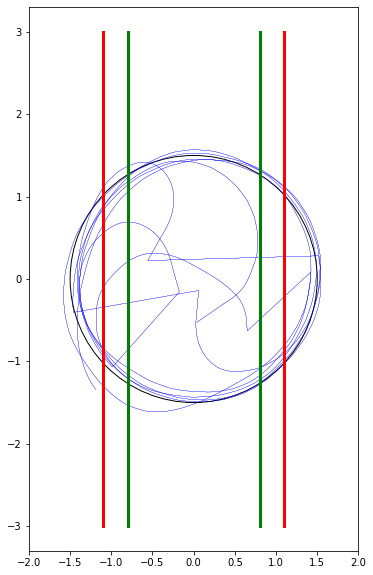

In [53]:
truly_safe_bounds = [-0.8,0.8]
marginally_safe_bounds = [-1.1,1.1]


plot_trajectories_df = trajectories_df

plot_trajectories(plot_trajectories_df,truly_safe_bounds,linewidth=0.1)


##### Behavior Cloning to Learn Safe Behaviour

In [ ]:
df = safe_trajectories_df[abs(safe_trajectories_df.x)>0.7]
expert_observations = df[[col for col in df.columns if 'obs_' in col]].values
expert_actions = df[[col for col in df.columns if 'act_' in col]].values

In [ ]:
num_interactions = len(safe_trajectories_df)
# expert_observations = np.empty((num_interactions,) + env.observation_space.shape)
# expert_actions = np.empty((num_interactions,) + env.action_space.shape)

np.savez_compressed(
   "test_data",
   expert_actions=expert_actions,
   expert_observations=expert_observations,
   )

In [ ]:
class ExpertDataSet(Dataset):
   def __init__(self, expert_observations, expert_actions):
      self.observations = expert_observations.astype(np.float32)
      self.actions = expert_actions.astype(np.float32)
   def __getitem__(self, index):
      return (self.observations[index], self.actions[index])
   def __len__(self):
      return len(self.observations)

In [ ]:
expert_dataset = ExpertDataSet(expert_observations, expert_actions)
train_size = int(0.8 * len(expert_dataset))
test_size = len(expert_dataset) - train_size
train_expert_dataset, test_expert_dataset = random_split(
     expert_dataset, [train_size, test_size]
     )

train_loader = DataLoader(train_expert_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_expert_dataset,batch_size=32,shuffle=True)

In [ ]:
# Step 2: Define your model
class CSP_NN(nn.Module):
    def __init__(self,num_input,num_output):
        super(CSP_NN, self).__init__()
        self.fc1 = nn.Linear(num_input, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)

        self.fc4 = nn.Linear(64, num_output)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = F.tanh(self.fc4(x))
        return x

num_input = 28
num_output = 2


In [ ]:
def train(model,train_loader,test_loader,num_epochs=100,lr = 0.001,print_every=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()
        for x,y in train_loader:
            optimizer.zero_grad()

            y_hat = model(x)
            loss = criterion(y_hat,y)
            loss.backward()
            optimizer.step()

            # print(loss.item())
            epoch_loss += loss.item()
            
        if epoch%print_every==0:

            with torch.no_grad():
                epoch_loss_test = 0
                for x,y in test_loader:
                    # optimizer.zero_grad()
                    y_hat = model(x)
                    loss = criterion(y_hat,y)
                    # loss.backward()
                    # optimizer.step()

                    epoch_loss_test += loss.item()

            print("Epoch: {} | Train Loss: {} | Test Loss: {}".format(epoch,epoch_loss/len(train_loader),epoch_loss_test/len(test_loader)))

    return model

model = CSP_NN(num_input,num_output)
model = train(model,train_loader,test_loader)

Epoch: 0 | Train Loss: 0.12609233463352376 | Test Loss: 0.04494369216263294


Epoch: 10 | Train Loss: 0.0004140376668973741 | Test Loss: 0.0003655812771674911
Epoch: 20 | Train Loss: 0.00015858549476516519 | Test Loss: 0.00013439297513936514
Epoch: 30 | Train Loss: 7.040246266776442e-05 | Test Loss: 0.00015120511410974098
Epoch: 40 | Train Loss: 0.0001916980532273142 | Test Loss: 0.00012825910796111981
Epoch: 50 | Train Loss: 0.0006444972038893452 | Test Loss: 0.00028485663018987646
Epoch: 60 | Train Loss: 6.867222929775546e-05 | Test Loss: 0.0001325254644533353
Epoch: 70 | Train Loss: 0.00027288921191939155 | Test Loss: 0.00048475529599402634
Epoch: 80 | Train Loss: 0.0010714801390845836 | Test Loss: 0.0011556241744463997
Epoch: 90 | Train Loss: 2.9517745910693934e-05 | Test Loss: 3.247765783141533e-05


#### Custom CSP Definition (Heuristic Based)

This implementation is for the SafetyCircle Environment only. However, similar heuristic based CSPs can be developed for other safety_gymnasium environments like SafeNavigation where obstacles with different costs need to be avoided.



In [13]:
agent_type = 'Point'
env_code = 1
env_name = 'Safety{}Circle{}Gymnasium-v0'.format(agent_type,env_code)
env = make_gymnasium_environment(env_name,render_mode=None)
episode = 0

In [35]:
def get_csp_action(x,y,theta_local_rad,csp_config):

    truly_safe_set_bound = csp_config['truly_safe_set_bound']
    y_bound = csp_config['y_bound']
    linear_vel_angle = csp_config['linear_vel_angle']
    no_turn_angle = csp_config['no_turn_angle']
    marginally_safe_set_bound = csp_config['marginally_safe_set_bound']


    theta_local = theta_local_rad*180/np.pi
    if abs(x)<=truly_safe_set_bound:
        act = np.array([0.1,np.random.uniform(-1,1)]) 
        # Inside the Truly Safe State Space, the agent is just made to go forward , hence the 0.1 (it can be any other action) 
        # we need our csp to act primarily in the marginally safe set, we do not care about its actions inside the truly safe set

    else:
        if x>truly_safe_set_bound and ((0<theta_local<180-no_turn_angle) or (180+no_turn_angle<theta_local<360)):
            if 0<theta_local<linear_vel_angle or (360-linear_vel_angle<theta_local<360):
                act_linear = -0.1
            else:
                act_linear = 0

            if (0<theta_local<160):
                act_angular = np.random.uniform(0.8,1)
            elif 200<theta_local<360:
                act_angular = -np.random.uniform(0.8,1)
            
            act = np.array([act_linear,act_angular])

            

        elif x<-truly_safe_set_bound and no_turn_angle<theta_local<360-no_turn_angle:
            if 180-linear_vel_angle<theta_local<180+linear_vel_angle:
                act_linear=-0.1
            else:
                act_linear = 0

            if 10<theta_local<180:
                act_angular = -np.random.uniform(0.8,1)
            else:
                act_angular = np.random.uniform(0.8,1)
            
            act = np.array([act_linear,act_angular])
      
        else:
            act = np.array([0.8,0])

    return act

In [36]:
obs, info = env.reset()

dummy_action = env.action_space.sample()
terminated, truncated = False, False
ep_ret, ep_cost = 0, 0
obs_len = env.observation_space.shape[0]
act_len = env.action_space.shape[0]
max_lidar_distance = 6
lidar_resolution = 16

num_episodes = 100

csp_config = {'truly_safe_set_bound':0.6,
              'marginally_safe_set_bound':1.1,
            'y_bound':2,
            'linear_vel_angle':40, # Within 40 degrees of pointing to the obstacle, there will be a negative linear force
            'no_turn_angle':20, # Within 20 degrees away from the wall, there will be no turning
            'parallel_angle':10} 

trajectories_df = get_trajectories_df()
df_row = np.zeros(len(trajectories_df.columns))
for _ in range(num_episodes):
    episode += 1
    ep_ret, ep_cost = 0, 0
    time_step = 0

    while True:
        time_step +=1
        assert env.observation_space.contains(obs)
        # act = env.action_space.sample()
        
        x,y,theta_local,info_lidar = get_coords(obs,max_lidar_distance,lidar_resolution)
        theta_local = scale_angle(theta_local*180/np.pi)*np.pi/180
        if info_lidar['within_limits']==False:
            print("AGENT OUTSIDE LIMITS | Episode: {} | Time Step: {} | Reward: {:.2f} | Cost: {:.2f}".format(episode,time_step,ep_ret,ep_cost))
            obs, info = env.reset()
            break

        act = get_csp_action(x,y,theta_local,csp_config)

        obs, reward, terminated, truncated, info = env.step(act)
        # print("Time Step: {} | a1: {:.2f} | a2: {:.2f} | a3: {:.2f} | v1: {:.2f} | v2: {:.2f} | v3: {:.2f} | ".format(time_step,obs[0],obs[1],obs[2],obs[3],obs[4],obs[5]))
        cost = info['cost']

        ep_ret += reward
        ep_cost += cost

        # Logging
        df_row[0] = env_code
        df_row[1] = episode
        df_row[2] = time_step
        df_row[3:3+obs_len] = obs
        df_row[3+obs_len:3+obs_len+3] = np.array([x,y,theta_local*180/np.pi])
        df_row[-2-act_len:-2] = act
        df_row[-2] = reward
        df_row[-1] = cost

        # print(df_row)
        trajectories_df.loc[len(trajectories_df.index)] = df_row

        if terminated or truncated:
            print("Episode: {} | Time Step: {} | Reward: {:.2f} | Cost: {:.2f}".format(episode,time_step,ep_ret,ep_cost))
            obs, info = env.reset()
            break
    
env.close()

Episode: 201 | Time Step: 500 | Reward: 3.35 | Cost: 0.00
Episode: 202 | Time Step: 500 | Reward: -1.20 | Cost: 0.00
Episode: 203 | Time Step: 500 | Reward: 1.40 | Cost: 0.00
AGENT OUTSIDE LIMITS | Episode: 204 | Time Step: 466 | Reward: -0.59 | Cost: 3.00
Episode: 205 | Time Step: 500 | Reward: -6.65 | Cost: 0.00
Episode: 206 | Time Step: 500 | Reward: -3.48 | Cost: 0.00
AGENT OUTSIDE LIMITS | Episode: 207 | Time Step: 256 | Reward: 1.38 | Cost: 0.00
Episode: 208 | Time Step: 500 | Reward: 4.50 | Cost: 0.00
Episode: 209 | Time Step: 500 | Reward: 6.57 | Cost: 0.00
Episode: 210 | Time Step: 500 | Reward: 4.23 | Cost: 0.00
Episode: 211 | Time Step: 500 | Reward: 5.36 | Cost: 0.00
Episode: 212 | Time Step: 500 | Reward: 0.70 | Cost: 0.00
Episode: 213 | Time Step: 500 | Reward: 3.59 | Cost: 0.00
Episode: 214 | Time Step: 500 | Reward: -2.41 | Cost: 0.00
Episode: 215 | Time Step: 500 | Reward: 4.65 | Cost: 0.00
Episode: 216 | Time Step: 500 | Reward: 5.64 | Cost: 0.00
Episode: 217 | Time S

#### Safe RL with SSS and CSP

In [9]:
class DDPGagent:
    def __init__(self, env,ddpg_agent_config_dict):
        
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = ddpg_agent_config_dict['gamma']
        self.tau = ddpg_agent_config_dict['tau']
        self.weight_decay_critic = ddpg_agent_config_dict['weight_decay_critic']
        self.weight_decay_actor = ddpg_agent_config_dict['weight_decay_actor']
        self.max_memory_size = ddpg_agent_config_dict['max_memory_size']
        self.actor_learning_rate = ddpg_agent_config_dict['actor_learning_rate']
        self.critic_learning_rate = ddpg_agent_config_dict['critic_learning_rate']
        self.hidden_size = ddpg_agent_config_dict['hidden_size']


        # Networks
        self.actor = Actor(self.num_states, self.hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, self.hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, self.hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, self.hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(self.max_memory_size)        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=self.actor_learning_rate, weight_decay=self.weight_decay_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.critic_learning_rate,weight_decay=self.weight_decay_critic)
    
    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size) #states = List of np arrays of shape (self.num_states,)
        # print(type(states))
        states = torch.Tensor(np.vstack(states))
        actions = torch.Tensor(np.vstack(actions))
        rewards = torch.Tensor(np.vstack(rewards))
        next_states = torch.Tensor(np.vstack(next_states))
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions) # shape = (batch_size, num_actions)
        next_actions = self.actor_target.forward(next_states) # shape = (batch_size, num_actions)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss_before_mean = -self.critic.forward(states, self.actor.forward(states))
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        # return 0,0
        # print("Qvals.shape: {} | Qprime.shape: {} | policy_loss_before_mean.shape: {} | critic_loss.shape: {}".format(Qvals.shape,Qprime.shape,policy_loss_before_mean.shape,critic_loss.shape))
        info_update = {'Qvals':Qvals.detach().norm()/Qvals.detach().numel(),
                       'Qprime':Qprime.detach().norm()/Qprime.detach().numel()}
        # info_update = {}
        return policy_loss.detach().item(),critic_loss.detach().item(),info_update
        
    
def print_logging_dict(logging_dict):

    for key in logging_dict:
        print("{}:{:.2f}".format(key,logging_dict[key]),end=' | ')

    print()


In [5]:
def get_safe_action(action,x,y,theta_local_rad,csp_config):

    truly_safe_set_bound = csp_config['truly_safe_set_bound']
    y_bound = csp_config['y_bound']
    linear_vel_angle = csp_config['linear_vel_angle']
    no_turn_angle = csp_config['no_turn_angle']
    parallel_angle = csp_config['parallel_angle']
    marginally_safe_set_bound = csp_config['marginally_safe_set_bound']


    theta_local = theta_local_rad*180/np.pi
    if abs(x)<=truly_safe_set_bound:
        act = action
        # act = np.array([0.1,0])

    # elif x>truly_safe_set_bound and x<marginally_safe_set_bound and 90+parallel_angle<theta_local<270-parallel_angle:
    #     act = action
    #     # print('here2')
    # elif x<=-truly_safe_set_bound and x>-marginally_safe_set_bound and (0<theta_local<90-parallel_angle or 170+parallel_angle<theta_local<360):
    #     act = action
        # print('here3')

    else:
        if x>truly_safe_set_bound and ((0<theta_local<180-no_turn_angle) or (180+no_turn_angle<theta_local<360)):
            if 0<theta_local<linear_vel_angle or (360-linear_vel_angle<theta_local<360):
                act_linear = -0.1
            else:
                act_linear = 0

            if (0<theta_local<160):
                act_angular = np.random.uniform(0.8,1)
            elif 200<theta_local<360:
                act_angular = -np.random.uniform(0.8,1)
            
            act = np.array([act_linear,act_angular])
            # act2 = np.array([-0.1,np.random.uniform(-1,-0.9)])
            # act_i = np.random.choice([0,1],p=[0.9,0.1])
            # act = [act1,act2][act_i]

            # act = -2*obs[:2]#np.array([0,0])
        # else:
        #     act = np.array([0.5,0])
        elif x<-truly_safe_set_bound and no_turn_angle<theta_local<360-no_turn_angle:
            if 180-linear_vel_angle<theta_local<180+linear_vel_angle:
                act_linear=-0.1
            else:
                act_linear = 0

            if 10<theta_local<180:
                act_angular = -np.random.uniform(0.8,1)
            else:
                act_angular = np.random.uniform(0.8,1)
            
            act = np.array([act_linear,act_angular])
            # act2 = np.array([-0.10,np.random.uniform(-1,-0.9)])
            # act_i = np.random.choice([0,1],p=[0.2,0.8])
            # act = [act1,act2][act_i]            
        else:
            act = np.array([0.8,0])
            # act = -2*obs[0:2]#np.array([0,0])

    return act

def train(agent,train_config_dict,csp_config):

    wandb_log = train_config_dict['wandb_log']
    num_episodes = train_config_dict['num_episodes']
    num_timesteps = train_config_dict['num_timesteps']
    epsilon = train_config_dict['epsilon']
    batch_size = train_config_dict['batch_size']

    if wandb_log:
        wandb.init(project='safety_gymnasium',config=train_config_dict)

    noise = OUNoise(env.action_space)
    rewards = []
    avg_rewards = []
    max_lidar_distance = 6
    lidar_resolution = 16
    info_update = {'Qvals':0,
                   'Qprime':0}

    for episode in range(num_episodes):
        state,info = env.reset()
        noise.reset()
        episode_reward = 0
        episode_cost = 0
        episode_policy_loss = 0
        episode_critic_loss = 0
        
        for step in range(num_timesteps):
            action = agent.get_action(state)
            action = action.squeeze()

            x,y,theta_local,info_lidar = get_coords(state,max_lidar_distance,lidar_resolution)
            theta_local = scale_angle(theta_local*180/np.pi)*np.pi/180
            if info_lidar['within_limits']==False:
                print("Episode: {} | AGENT OUTSIDE LIMITS".format(episode))
                obs, info = env.reset()
                break

            if np.random.uniform(0,1)>=epsilon:
                # print('#######safe action')
                # raise
                filtered_action = get_safe_action(action,x,y,theta_local,csp_config)
            else:
                raise
                filtered_action=action


            new_state, reward, terminated, truncated, info = env.step(filtered_action)
            cost = info['cost']
            if epsilon == 1:
                agent.memory.push(state, action, reward-cost, new_state, terminated)
            else:
                agent.memory.push(state, action, reward, new_state, terminated)

            if len(agent.memory) > batch_size:
                policy_loss, critic_loss, info_update = agent.update(batch_size)       
                episode_policy_loss += (policy_loss)
                episode_critic_loss += (critic_loss) 
            
            state = new_state
            episode_reward += reward
            episode_cost += cost


            if terminated or truncated:
                # print("Episode: {} | Reward: {:.2f} | Cost : {:.2f}".format(episode, episode_reward, episode_cost))


                logging_dict = {'Episode':episode,
                                'Reward': episode_reward,
                                'Cost':episode_cost,
                                'Actor Loss':episode_policy_loss,
                                'Critic Loss':episode_critic_loss,
                                'Qvals.norm':info_update['Qvals'],
                                'Qprime.norm':info_update['Qprime']
                                }
                
                if wandb_log:
                    wandb.log(logging_dict,step=100+episode)
                print_logging_dict(logging_dict) 
                break

        rewards.append(episode_reward)

    if wandb_log:
        wandb.finish()

    return agent
    # Took 30 seconds for 10 epochs when floattensor is used
    # Took 26 seconds for 10 epochs when floattensor was avoided

In [16]:
agent_type = 'Point'
env_code = 1
env_name = 'Safety{}Circle{}Gymnasium-v0'.format(agent_type,env_code)
env = make_gymnasium_environment(env_name,render_mode=None)

In [20]:
csp_config = {'truly_safe_set_bound':0.6,
              'marginally_safe_set_bound':1.1,
            'y_bound':2,
            'linear_vel_angle':40, # Within 40 degrees of pointing to the obstacle, there will be a negative linear force
            'no_turn_angle':20,
            'parallel_angle':2} # Within 20 degrees away from the wall, there will be no turning

train_config_dict = {'wandb_log':True,
                     'num_episodes':50,
                     'num_timesteps':500,
                     'epsilon':0,
                     'batch_size':512,
}

ddpg_agent_config_dict = {'hidden_size':256,
                            'actor_learning_rate':1e-4,
                            'critic_learning_rate':1e-3,
                            'gamma':0.99,
                            'tau':1e-2,
                            'max_memory_size':50000,
                            'weight_decay_actor':0,
                            'weight_decay_critic':0}

for _ in range(1):
  
    # agent = DDPGagent(env,ddpg_agent_config_dict)
    agent = train(agent,train_config_dict,csp_config)

Actor Loss,▁
Cost,▁
Critic Loss,▁
Episode,▁
Qprime.norm,▁
Qvals.norm,▁
Reward,▁
Actor Loss,-1963.79284
Cost,0.0
Critic Loss,10.05036
Episode,0


Episode:0.00 | Reward:13.38 | Cost:0.00 | Actor Loss:-1956.19 | Critic Loss:8.10 | Qvals.norm:0.14 | Qprime.norm:0.14 | 
Episode:1.00 | Reward:19.76 | Cost:0.00 | Actor Loss:-1957.54 | Critic Loss:12.85 | Qvals.norm:0.13 | Qprime.norm:0.13 | 
Episode:2.00 | Reward:3.88 | Cost:0.00 | Actor Loss:-1942.77 | Critic Loss:10.01 | Qvals.norm:0.13 | Qprime.norm:0.13 | 
Episode:3.00 | Reward:13.03 | Cost:0.00 | Actor Loss:-1932.49 | Critic Loss:8.09 | Qvals.norm:0.13 | Qprime.norm:0.13 | 
Episode:4.00 | Reward:-1.05 | Cost:0.00 | Actor Loss:-1925.54 | Critic Loss:8.88 | Qvals.norm:0.13 | Qprime.norm:0.13 | 
Episode:5.00 | Reward:-1.02 | Cost:0.00 | Actor Loss:-1914.13 | Critic Loss:8.66 | Qvals.norm:0.13 | Qprime.norm:0.13 | 
Episode:6.00 | Reward:3.86 | Cost:0.00 | Actor Loss:-1914.45 | Critic Loss:9.46 | Qvals.norm:0.13 | Qprime.norm:0.13 | 
Episode:7.00 | Reward:2.25 | Cost:0.00 | Actor Loss:-1904.88 | Critic Loss:9.12 | Qvals.norm:0.13 | Qprime.norm:0.13 | 
Episode:8.00 | Reward:4.03 | Cost

Actor Loss,██████████▇▇▇▆▆▆▆▆▅▅▅▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▂▂▂
Cost,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Critic Loss,▁▃▂▁▂▂▂▂▃▃▄▄▆▇▆▆▆▆█▇█▇▅▆▆▅▅▅▆▆▆▅▅▄▄▃▃▂▂▁
Episode,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Qprime.norm,▂▂▂▂▂▁▁▁▁▂▂▂▂▃▃▄▅▄▅▆▅▆▇▆▆▇▇▇▇▇▇▇██▇▇▇▇▇▇
Qvals.norm,▂▂▂▂▂▁▁▁▁▂▂▂▂▃▃▄▄▄▅▆▅▆▇▆▆▇▇▇▇▇▇▇██▇▇▇▇▇▇
Reward,▆▇▃▆▂▃▃▃▄▂▃▁▄▃▄▅▂▂▆▁▂▇▇▇▇▃█▄▇█▇██▅▁▇▄▅▅▄
Actor Loss,-2667.36048
Cost,0.0
Critic Loss,7.24569
Episode,48


#### Visualise Agent

In [8]:
def test_agent(agent,test_config_dict,csp_config):

    wandb_log = test_config_dict['wandb_log']
    num_test_episodes = test_config_dict['num_test_episodes']
    render = test_config_dict['render']
    action_source = test_config_dict['agent/csp']

    if wandb_log:
        wandb.init(project='safety_gymnasium',config=test_config_dict)

    agent_type = 'Point'
    env_code = 1
    env_name = 'Safety{}Circle{}Gymnasium-v0'.format(agent_type,env_code)
    if render:
        env = make_gymnasium_environment(env_name,render_mode='human')
    else:
        env = make_gymnasium_environment(env_name,render_mode=None)

    obs, info = env.reset()
    dummy_action = env.action_space.sample()
    terminated, truncated = False, False
    ep_ret, ep_cost = 0, 0
    obs_len = env.observation_space.shape[0]
    act_len = env.action_space.shape[0]
    max_lidar_distance = 6
    lidar_resolution = 16



    episode = 0
    for _ in range(num_test_episodes):
        episode += 1
        ep_ret, ep_cost = 0, 0
        time_step = 0

        while True:
            time_step +=1
            assert env.observation_space.contains(obs)
   



            x,y,theta_local,info_lidar = get_coords(obs,max_lidar_distance,lidar_resolution)
            theta_local = scale_angle(theta_local*180/np.pi)*np.pi/180
            if info_lidar['within_limits']==False:
                print("Episode: {} | AGENT OUTSIDE LIMITS".format(episode))
                obs, info = env.reset()
                break

            if action_source=='csp':
                action = get_csp_action(x,y,theta_local,csp_config) 

            elif action_source=='agent':
                action = agent.get_action(obs)
                action = action.squeeze()  

                # action = get_safe_action(action,x,y,theta_local,csp_config)
            else:
                raise

            obs, reward, terminated, truncated, info = env.step(action)
            # print("Time Step: {} | a1: {:.2f} | a2: {:.2f} | a3: {:.2f} | v1: {:.2f} | v2: {:.2f} | v3: {:.2f} | ".format(time_step,obs[0],obs[1],obs[2],obs[3],obs[4],obs[5]))
            cost = info['cost']

            ep_ret += reward
            ep_cost += cost

            if terminated or truncated:
                # print("Episode: {} | Time Step: {} | Reward: {:.2f} | Cost: {:.2f}".format(episode,time_step,ep_ret,ep_cost))
                obs, info = env.reset()

                logging_dict = {'Evaluation/Episode':episode,
                                'Evaluation/TimeStep':time_step,
                                'Evaluation/Reward': ep_ret,
                                'Evaluation/Cost':ep_cost
                                }
                
                if wandb_log:
                    wandb.log(logging_dict)
                print_logging_dict(logging_dict) 
                
                break
        
    if wandb_log:
        wandb.finish()
    env.close()

In [24]:
test_config_dict = {'wandb_log':False,
                    'num_test_episodes':10,
                    'render':True,
                    'agent/csp':'agent'}

csp_config = {'truly_safe_set_bound':0.55,
              'marginally_safe_set_bound':1.1,
            'y_bound':2,
            'linear_vel_angle':40, # Within 40 degrees of pointing to the obstacle, there will be a negative linear force
            'no_turn_angle':20,
            'parallel_angle':10} # Within 20 degrees away from the wall, there will be no turning

for i in range(1):
  print("Experiment: {}".format(i))
  test_agent(agent=agent,test_config_dict=test_config_dict,csp_config=csp_config)

Experiment: 0
Episode: 1 | AGENT OUTSIDE LIMITS
Episode: 2 | AGENT OUTSIDE LIMITS
Evaluation/Episode:3.00 | Evaluation/TimeStep:500.00 | Evaluation/Reward:21.99 | Evaluation/Cost:0.00 | 
Evaluation/Episode:4.00 | Evaluation/TimeStep:500.00 | Evaluation/Reward:6.12 | Evaluation/Cost:0.00 | 
Evaluation/Episode:5.00 | Evaluation/TimeStep:500.00 | Evaluation/Reward:11.36 | Evaluation/Cost:0.00 | 
Evaluation/Episode:6.00 | Evaluation/TimeStep:500.00 | Evaluation/Reward:11.49 | Evaluation/Cost:0.00 | 
Evaluation/Episode:7.00 | Evaluation/TimeStep:500.00 | Evaluation/Reward:17.81 | Evaluation/Cost:0.00 | 
Evaluation/Episode:8.00 | Evaluation/TimeStep:500.00 | Evaluation/Reward:-3.01 | Evaluation/Cost:70.00 | 
Episode: 9 | AGENT OUTSIDE LIMITS
Evaluation/Episode:10.00 | Evaluation/TimeStep:500.00 | Evaluation/Reward:6.57 | Evaluation/Cost:0.00 | 


In [ ]:
x_list, y_list, theta_list = [],[],[]

for experience in agent.memory.buffer:
    state, action, reward, next_state, done = experience
    x,y,theta_local,info_lidar = get_coords(state,max_lidar_distance,lidar_resolution)

    if info_lidar['within_limits']==False:
        print('Out of Limits')
        continue

    x_list.append(x)
    y_list.append(y)
    theta_list.append(theta_local)
    
    
    # state_batch.append(state)
    # action_batch.append(action)
    # reward_batch.append(reward)
    # next_state_batch.append(next_state)
    # done_batch.append(done)

In [34]:
states, actions, rewards, next_states, _ = agent.memory.sample(batch_size)
np.vstack(states).shape

(128, 28)

#### Response Curves for Different Linear Velocities

In [ ]:
obs, info = env.reset()

dummy_action = env.action_space.sample()
terminated, truncated = False, False
ep_ret, ep_cost = 0, 0
obs_len = env.observation_space.shape[0]
act_len = env.action_space.shape[0]
max_lidar_distance = 6
lidar_resolution = 16

num_episodes = 1
truly_safe_set_bound = 0.7
y_bound = 2
# df_row = np.zeros(len(trajectories_df.columns))
obs_dict = {}
act_list = [0.01,0.05,0.1,0.5,1]
for act_linear in act_list:
    obs_list =[]

    for _ in range(num_episodes):
        episode += 1
        ep_ret, ep_cost = 0, 0
        time_step = 0

        while True:
            time_step +=1
            assert env.observation_space.contains(obs)
            
            x,y,theta_local,info_lidar = get_coords(obs,max_lidar_distance,lidar_resolution)
            theta_local = scale_angle(theta_local*180/np.pi)*np.pi/180
            if info_lidar['within_limits']==False:
                print("Episode: {} | AGENT OUTSIDE LIMITS".format(episode))
                obs, info = env.reset()
                break

            act = np.array([act_linear,0])
            obs, reward, terminated, truncated, info = env.step(act)
            obs_list.append(obs)
            print("Time Step: {} | a1: {:.2f} | a2: {:.2f} | a3: {:.2f} | v1: {:.2f} | v2: {:.2f} | v3: {:.2f} | ".format(time_step,obs[0],obs[1],obs[2],obs[3],obs[4],obs[5]))
            cost = info['cost']

            ep_ret += reward
            ep_cost += cost

            if terminated or truncated:
                print("Episode: {} | Reward: {:.2f} | Cost: {:.2f}".format(episode,ep_ret,ep_cost))
                obs, info = env.reset()
                break
    
    obs_dict[act_linear]=np.array(obs_list)
env.close()

In [ ]:
# a = 0.01
fig,ax = plt.subplots(len(act_list),6,figsize=(20,30))
names = ['a1','a2','a3','v1','v2','v3']

for i,act_linear in enumerate(act_list):
    for j in range(6):
        obs_name = names[j]
        y = obs_dict[act_linear][:,j]
        ax[i][j].plot(y)
        ax[i][j].set_title("Act_{}_{}".format(act_linear,obs_name))
        if j==3:
            ax[i][j].set_ylim([0,1.6])

plt.tight_layout()

### Old Code (Video Saving, Stochastic CSP etc)


In [ ]:
def generate_frames(env,action,num_time_steps):

    obs, info = env.reset()
    # Set seeds
    # obs, _ = env.reset(seed=0)
    terminated, truncated = False, False
    ep_ret, ep_cost = 0, 0
    video_frames = []
    observations_lidar = []
    for _ in range(num_time_steps):
        assert env.observation_space.contains(obs)
        act = env.action_space.sample()
        act = action
        assert env.action_space.contains(act)
        # modified for Safe RL, added cost
        obs, reward, cost, terminated, truncated, info = env.step(act)
        ep_ret += reward
        ep_cost += cost
        # Logging
        # video_frames.append(env.render())
        # observations_lidar.append(obs[-16:].reshape(-1,1))
        if terminated or truncated:
            
            observation, info = env.reset()

        env.close()

        video_frames.append(env.render())

    return video_frames

In [ ]:
def save_video(video_frames,output_video_filename):
    width, height,_ = video_frames[0].shape

    fps = 30

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_filename, fourcc, fps, (width, height))

    for frame_rgb in video_frames:
        frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)

    out.release()

In [ ]:
a1_list = [-0.5]
a2_list = [-0.5]

if agent_type=='Point':
    a1_name = 'v' # name of the first action
    a2_name = 'w' # name of the second action
elif agent_type=='Car':
    a1_name = 'l' # name of the first action
    a2_name = 'r' # name of the second action

experiments = {}
for a1 in a1_list:
    for a2 in a2_list:
        experiment_name = a1_name+str(a1)+'_'+a2_name+str(a2)
        experiments[experiment_name] = np.array([a1,a2])


print(experiments)

num_time_steps = 200
folder_name = 'Videos/Experiments_{}'.format(agent_type)
file_prefix = 'CircleEnv_'

for k,v in experiments.items():
    video_frames = generate_frames(env,v,num_time_steps)
    output_video_filename = folder_name+'/'+file_prefix+k+'.mp4'
    save_video(video_frames,output_video_filename)

In [ ]:
env = safety_gymnasium.make('Safety{}Circle1-v0'.format(agent_type), render_mode='rgb_array')

num_time_steps = 10
folder_name = 'Videos/Experiments_{}'.format(agent_type)
file_prefix = 'New_'
v = np.array([0.1,0.5])
k = 'v0.1_w0.5'


video_frames = generate_frames(env,v,num_time_steps)
output_video_filename = folder_name+'/'+file_prefix+k+'.mp4'
save_video(video_frames,output_video_filename)

In [ ]:
num_time_steps=1000
video_frames = generate_frames(env,v,num_time_steps)


In [ ]:
def run_exp():
    global ACTION

    agent_type = 'Point'
    # env = safety_gymnasium.make('Safety{}Circle1Debug-v0'.format(agent_type), render_mode='human')

    env = safety_gymnasium.make("Safety{}Circle1-v0".format(agent_type), render_mode='human')

    # env.reset()
    obs, info = env.reset()
    # Set seeds
    # obs, _ = env.reset(seed=0)
    terminated, truncated = False, False
    ep_ret, ep_cost = 0, 0
    video_frames = []
    observations_lidar = []
    num_time_steps = 10000
    for t in range(num_time_steps):
        assert env.observation_space.contains(obs)
        act = env.action_space.sample()
        # if t<500:
            # act = np.array([1,1])
        # elif t>=50 and t<=100:
        #     act = np.array([-1,-1])
        # else:
        #     act = np.array([0,0])
        assert env.action_space.contains(act)
        # print(obs[-16:].round(1))
        # modified for Safe RL, added cost
        print(ACTION)
        obs, reward, cost, terminated, truncated, info = env.step(ACTION)
        # if t%10==0:
        # print("Reward: {:.2f} | Cost: {:.2f}".format(1000*reward,cost))
        print("Acc: {:.2f},{:.2f},{:.2f} | Vel: {:.2f},{:.2f},{:.2f} | Omega: {:.2f},{:.2f},{:.2f} ".format(obs[0],obs[1],obs[2],obs[3],obs[4],obs[5],obs[6],obs[7],obs[8]))
        ep_ret += reward
        ep_cost += cost
        # Logging
        # video_frames.append(env.render())
        # observations_lidar.append(obs[-16:].reshape(-1,1))
        if terminated or truncated:
            print("### Episode Terminated ###")
            observation, info = env.reset()

        # env.close()

        video_frames.append(env.render())

# def update_action():
#     global ACTION
#     ACTION = np.array([0,0.1])+ACTION
#     time.sleep(0.1)

ACTION = np.array([0,0])

def on_press(key):
    global obs
    global ACTION
    # print('{0} pressed'.format(key))
    
    if key == 'Key.up':
        action = np.array([1,0])
    elif key == Key.down:
        action = np.array([-1,0])

    elif key == Key.left:
        action = np.array([0,1])

    elif key == Key.right:
        action = np.array([0,-1])

    # elif key == Key.space:
    #     action = np.array([0,0])
    
    else:
        action = np.array([0,0])
        print("Invalid Key, only arrow keys and space allowed")

    ACTION = action

def on_release(key):
    global ACTION
    action = np.array([0,0])

    # print('{0} released'.format(key))
    ACTION = action


def key_handling():
    with Listener(
        on_press=on_press,on_release=on_release) as listener:
        listener.join()

# agent_type = 'Point'
# env = safety_gymnasium.make('Safety{}Circle1-v0'.format(agent_type), render_mode='human')
# env.reset()
# # env.render()

# obs, info = env.reset()
# terminated, truncated = False, False
# ep_ret, ep_cost = 0, 0
# video_frames = []a

# agent = Agent_Env(env)
thread_key = Thread(target=key_handling)
thread_key.start()

thread_action = Thread(target=run_exp)
thread_action.start()


In [ ]:
from pynput.keyboard import Key, Listener
from threading import Thread
import numpy as np
import safety_gymnasium
import cv2
import matplotlib.pyplot as plt
import numpy as np

class Agent_Env:
    def __init__(self,env):

        self.ep_ret = 0
        self.ep_cost = 0
        self.video_frames = []
        self.env = env
        obs, info = env.reset()
        self.obs = obs

    def take_step(self,act):
        global ACTION
        act = ACTION
        print(act)

        # assert self.env.observation_space.contains(obs)
        assert self.env.action_space.contains(act)
        self.obs, reward, cost, terminated, truncated, info = self.env.step(act)
        print('here0')
        self.ep_ret += reward
        self.ep_cost += cost
        print('here1')
        if terminated or truncated:
            
            self.obs, info = self.env.reset()

        self.self.env.close()
        print('herer')
        self.video_frames.append(self.env.render())

    def get_state(self):
        print(self.obs[0])

    

    

obs, info = env.reset()
terminated, truncated = False, False
ep_ret, ep_cost = 0, 0
video_frames = []

ACTION = None
def on_press(key):
    global obs
    print('{0} pressed'.format(key))
    
    if key == Key.up:
        action = np.array([1,0])
    elif key == Key.down:
        action = np.array([-1,0])

    elif key == Key.left:
        action = np.array([0,1])

    elif key == Key.right:
        action = np.array([0,-1])

    # elif key == Key.space:
    #     action = np.array([0,0])
    
    else:
        action = np.array([0,0])
        print("Invalid Key, only arrow keys and space allowed")

    ACTION = action
    # # agent.take_step(action)
    # assert env.observation_space.contains(obs)
    # act = env.action_space.sample()
    # act = action
    # assert env.action_space.contains(act)
    # # modified for Safe RL, added cost
    # obs, reward, cost, terminated, truncated, info = env.step(act)
    # ep_ret += reward
    # ep_cost += cost
    # # Logging
    # # video_frames.append(env.render())
    # # observations_lidar.append(obs[-16:].reshape(-1,1))
    # if terminated or truncated:
        
    #     observation, info = env.reset()

    # # env.close()

    # video_frames.append(env.render())

def on_release(key):
    action = np.array([0,0])

    print('{0} released'.format(key))
    ACTION = action


def key_handling():
    with Listener(
        on_press=on_press) as listener:
        listener.join()

def run_exp():
    print(ACTION)

# env = safety_gymnasium.make('SafetyPointCircle1-v0', render_mode='rgb_array')
agent_type = 'Point'
env = safety_gymnasium.make('Safety{}Circle1-v0'.format(agent_type), render_mode='human')
env.reset()

# obs, info = env.reset()
# terminated, truncated = False, False
# ep_ret, ep_cost = 0, 0
# video_frames = []

agent = Agent_Env(env)
thread_key = Thread(target=key_handling)
thread_key.start()


In [ ]:
from pynput.keyboard import Key, Listener
from threading import Thread

def on_press(key):
    print(1)
def key_handling():

    with Listener(
        on_press=on_press) as listener:
        listener.join()

thread_key = Thread(target=key_handling)
thread_key.start()

In [ ]:
import keyboard

while True:
    keyboard.on_press_key("P", lambda _:print("You pressed p"))
    

keyboard.unhook_all()


#### Graphs

In [37]:
import matplotlib.pyplot as plt
from scipy.special import beta as beta_function


In [38]:
def beta_pdf(x, alpha, beta):
    # Compute the PDF of beta distribution at x
    pdf = (x**(alpha - 1) * (1 - x)**(beta - 1)) / beta_function(alpha, beta)
    return pdf

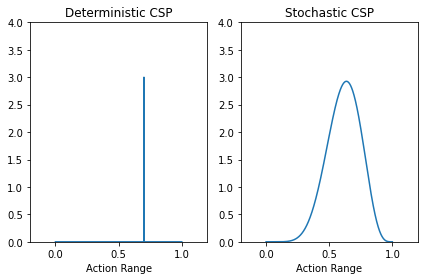

In [57]:
action_range = [0,1]
resolution = 1000
x_csp_det = 0.7

x_axis = np.linspace(action_range[0],action_range[1],resolution)
y_axis_det = np.zeros(resolution)
x_idx = int(resolution*(x_csp_det-action_range[0])/(action_range[1]-action_range[0]))
x_range = action_range[1]-action_range[0]
y_axis_det[x_idx] = 3





# Parameters of the beta distribution
alpha = 8.0  # shape parameter alpha (> 0)
beta = 5.0   # shape parameter beta (> 0)

# Generate x values for PDF plot
x = np.linspace(0, 1, resolution)

# Calculate the PDF values
y_axis_beta = beta_pdf(x, alpha, beta)

fig,ax = plt.subplots(1,2)
ax[0].plot(x_axis,y_axis_det)
ax[0].set_xlim([-0.2,1.2])
ax[0].set_ylim([0,4])

ax[1].plot(x_axis,y_axis_beta)
ax[1].set_xlim([-0.2,1.2])
ax[1].set_ylim([0,4])

ax[0].set_title('Deterministic CSP')
ax[1].set_title('Stochastic CSP')
ax[0].set_xlabel('Action Range')
ax[1].set_xlabel('Action Range')


plt.tight_layout()

In [ ]:
obs, info = env.reset()
# Set seeds
# obs, _ = env.reset(seed=0)

dummy_action = env.action_space.sample()
terminated, truncated = False, False
ep_ret, ep_cost = 0, 0
# video_frames = []
# observations_lidar = []
num_episodes = 10
for episode in range(num_episodes):
        
    while True:
        assert env.observation_space.contains(obs)
        # act = env.action_space.sample()
        # if t<500:
            # act = np.array([1,1])
        # elif t>=50 and t<=100:
        #     act = np.array([-1,-1])
        # else:
        #     act = np.array([0,0])
        # assert env.action_space.contains(act)
        # print(obs[-16:].round(1))
        # modified for Safe RL, added cost
        # print(act)
        obs, reward, cost, terminated, truncated, info = env.step(dummy_action)
        lidar_values = obs[-16:]
        # print(np.round(lidar_values,1))
        # print(info['action_keyboard'])
        # if t%10==0:
        # print("Reward: {:.2f} | Cost: {:.2f}".format(1000*reward,cost))
        # print("Acc: {:.2f},{:.2f},{:.2f} | Vel: {:.2f},{:.2f},{:.2f} | Omega: {:.2f},{:.2f},{:.2f} ".format(obs[0],obs[1],obs[2],obs[3],obs[4],obs[5],obs[6],obs[7],obs[8]))
        ep_ret += reward
        ep_cost += cost
        # Logging
        # video_frames.append(env.render())
        # observations_lidar.append(obs[-16:].reshape(-1,1))

        if terminated or truncated:
            print("Episode: {} | Reward: {:.2f} | Cost: {:.2f}".format(episode,ep_ret,ep_cost))
            observation, info = env.reset()
            break

    # env.close()

    # video_frame = env.render()
    # cv2.imshow("Frame",video_frame)
    # key = cv2.waitKey(10)
    # # print(key)
    # if key == ord('q'):
    #     print("### Episode Terminated ###")
    #     break
    # video_frames.append(env.render())
# env.close()
# cv2.destroyAllWindows()
env.close()